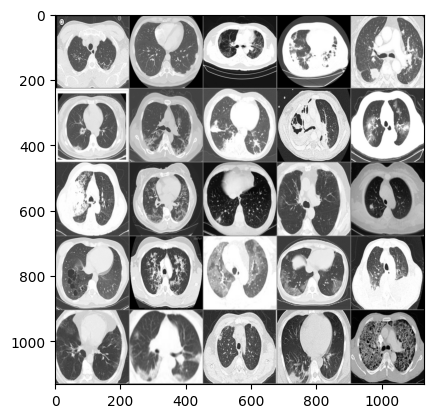

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration options
k_folds = 5
num_epochs = 50
batch_size = 100
learning_rate = 0.001

# Define a custom transformation to convert RGB to grayscale
class RGBtoGray:
    def __call__(self, img):
        # Convert the PIL Image to grayscale
        gray_img = img.convert('L')
        return gray_img

# transform
transform = transforms.Compose(
    [RGBtoGray(),
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

train_dataset=torchvision.datasets.ImageFolder(root='../COVID-19-Lung-CT-Scans-Classification-CNN/Data_dir/train data', transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root='../COVID-19-Lung-CT-Scans-Classification-CNN/Data_dir/test data', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

classes = ('CT_COVID', 'CT_NonCOVID')

def imshow(imgs):
    imgs = imgs / 2 + 0.5     # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))  
    plt.show()

# one batch of random training images
# Iterate through the batches in the DataLoader
for images, labels in train_loader:
    img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
    imshow(img_grid)
    break  # Display images from the first batch and then exit the loop


In [2]:
print(device)

cuda


In [3]:
from tqdm.notebook import tqdm

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        
        self.fc1 = nn.Linear(in_features=1024*1*1, out_features=512)
        
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        
        self.fc3 = nn.Linear(in_features=128, out_features=2)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # print(out.shape)
        out = self.layer4(out)
        # print(out.shape)
        out = self.layer5(out)
        # print(out.shape)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        # print(out.shape)
        out = self.dropout(out)
        out = self.fc2(out)
        # print(out.shape)
        out = self.dropout(out)
        out = self.fc3(out)
        # print(out.shape)
        return out


def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [4]:
from sklearn.metrics import f1_score
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score



# For fold results
results = {"accuracy": [], "f1_score": [], "precision" :[],"recall": [], "history": []}

# Set fixed random number seed
torch.manual_seed(42)

dataset = ConcatDataset([train_dataset, test_dataset])

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    # print the size of test and train data
    print(f'Train IDs: {len(train_ids)} | Test IDs: {len(test_ids)}')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=test_subsampler)

    # Init the neural network
    model = ConvNet().to(device)
    model.apply(reset_weights)

    # Initialize optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store the training and test history
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    # Run the training loop for defined number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for i, (images, labels) in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(trainloader)

        # Testing loop (to calculate test loss and accuracy)
        model.eval()  # Set the model to evaluation mode
        correct_test = 0
        total_test = 0
        test_running_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Calculate test accuracy and loss
        test_accuracy = 100 * correct_test / total_test
        test_loss = test_running_loss / len(testloader)

        # Append to the history lists
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)

    # Get predictions for the test data
    y_pred = []
    y_true = []

    with torch.no_grad():
        n_correct = 0
        n_samples = len(test_ids)

        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # value, index
            _, predictions = torch.max(outputs, 1)
            n_correct += (predictions == labels).sum().item()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the {n_samples} test images: {acc} %')
        # Calculate the F1 Score
        f1 = f1_score(y_true, y_pred, average='macro')
        print(f'The F1 Score is {f1:.3f}')
        # Calculate precision and recall
        precision = precision_score(y_true, y_pred, average='macro',zero_division=0)  # Change 'macro' to 'micro' or 'weighted' as needed
        recall = recall_score(y_true, y_pred, average='macro',zero_division=0)  # Change 'macro' to 'micro' or 'weighted' as needed

        # Save results per fold
        results["accuracy"].append(acc)
        results["f1_score"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["history"].append({
            "train_loss": train_loss_history,
            "train_acc": train_accuracy_history,
            "test_loss": test_loss_history,
            "test_acc": test_accuracy_history
        })

# Process is complete.
print('Training process has finished.')

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
avg_acc = sum(results["accuracy"]) / k_folds
avg_f1 = sum(results["f1_score"]) / k_folds
avg_precision = sum(results["precision"]) / k_folds
avg_recall = sum(results["recall"]) / k_folds
print(f'Average model accuracy: {avg_acc:.2f} %')
print(f'Average F1 Score: {avg_f1:.3f}')
print(f'Average precision score: {avg_precision:.3f}')
print(f'Average recall score: {avg_recall:.3f}')


--------------------------------
FOLD 0
--------------------------------
Train IDs: 596 | Test IDs: 150
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
R

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.4980, Train Accuracy: 50.84%, Test Loss: 0.7165, Test Accuracy: 48.67%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.7836, Train Accuracy: 55.20%, Test Loss: 0.6726, Test Accuracy: 66.67%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.7751, Train Accuracy: 62.92%, Test Loss: 0.6290, Test Accuracy: 63.33%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.7158, Train Accuracy: 62.08%, Test Loss: 0.5704, Test Accuracy: 68.00%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6822, Train Accuracy: 66.28%, Test Loss: 0.7449, Test Accuracy: 54.00%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6582, Train Accuracy: 67.28%, Test Loss: 0.6170, Test Accuracy: 70.00%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.6385, Train Accuracy: 72.99%, Test Loss: 0.8309, Test Accuracy: 59.33%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.5497, Train Accuracy: 75.17%, Test Loss: 0.5832, Test Accuracy: 66.67%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5119, Train Accuracy: 76.17%, Test Loss: 1.2640, Test Accuracy: 51.33%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.4693, Train Accuracy: 80.20%, Test Loss: 1.6180, Test Accuracy: 52.00%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.4329, Train Accuracy: 81.04%, Test Loss: 0.6099, Test Accuracy: 68.67%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.4570, Train Accuracy: 81.38%, Test Loss: 0.5912, Test Accuracy: 78.67%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.3370, Train Accuracy: 84.40%, Test Loss: 0.8312, Test Accuracy: 74.00%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.3648, Train Accuracy: 86.74%, Test Loss: 0.5503, Test Accuracy: 78.00%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.3050, Train Accuracy: 87.58%, Test Loss: 1.5056, Test Accuracy: 64.67%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.3135, Train Accuracy: 86.91%, Test Loss: 1.6733, Test Accuracy: 58.00%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.3273, Train Accuracy: 86.58%, Test Loss: 0.6024, Test Accuracy: 78.67%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.2202, Train Accuracy: 92.62%, Test Loss: 0.6508, Test Accuracy: 78.67%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.1971, Train Accuracy: 92.28%, Test Loss: 2.4211, Test Accuracy: 52.67%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.2242, Train Accuracy: 91.78%, Test Loss: 0.9010, Test Accuracy: 75.33%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1467, Train Accuracy: 94.63%, Test Loss: 1.3790, Test Accuracy: 65.33%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0963, Train Accuracy: 95.81%, Test Loss: 0.6102, Test Accuracy: 82.00%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0666, Train Accuracy: 97.32%, Test Loss: 0.6483, Test Accuracy: 84.00%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0637, Train Accuracy: 96.64%, Test Loss: 2.0387, Test Accuracy: 71.33%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0940, Train Accuracy: 96.31%, Test Loss: 0.9906, Test Accuracy: 77.33%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0567, Train Accuracy: 98.32%, Test Loss: 1.6738, Test Accuracy: 69.33%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0400, Train Accuracy: 97.99%, Test Loss: 1.6002, Test Accuracy: 76.67%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0215, Train Accuracy: 99.50%, Test Loss: 1.9236, Test Accuracy: 68.00%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0161, Train Accuracy: 99.33%, Test Loss: 2.0052, Test Accuracy: 76.67%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0139, Train Accuracy: 99.50%, Test Loss: 1.0181, Test Accuracy: 81.33%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0095, Train Accuracy: 99.83%, Test Loss: 1.3130, Test Accuracy: 77.33%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0287, Train Accuracy: 98.99%, Test Loss: 1.3964, Test Accuracy: 76.67%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0210, Train Accuracy: 99.16%, Test Loss: 2.7030, Test Accuracy: 70.00%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0147, Train Accuracy: 99.33%, Test Loss: 2.3535, Test Accuracy: 72.67%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0369, Train Accuracy: 98.99%, Test Loss: 1.4610, Test Accuracy: 78.67%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0107, Train Accuracy: 99.50%, Test Loss: 0.8840, Test Accuracy: 83.33%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0482, Train Accuracy: 97.82%, Test Loss: 1.1636, Test Accuracy: 80.00%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0377, Train Accuracy: 98.83%, Test Loss: 1.6487, Test Accuracy: 74.67%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0529, Train Accuracy: 98.49%, Test Loss: 0.9132, Test Accuracy: 86.00%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0486, Train Accuracy: 97.82%, Test Loss: 4.3532, Test Accuracy: 62.00%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.1011, Train Accuracy: 96.81%, Test Loss: 1.0127, Test Accuracy: 82.00%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0820, Train Accuracy: 97.65%, Test Loss: 4.3502, Test Accuracy: 61.33%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0580, Train Accuracy: 97.99%, Test Loss: 1.4001, Test Accuracy: 72.67%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0420, Train Accuracy: 98.49%, Test Loss: 1.0946, Test Accuracy: 71.33%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0308, Train Accuracy: 98.66%, Test Loss: 1.4528, Test Accuracy: 78.67%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0123, Train Accuracy: 99.83%, Test Loss: 2.1322, Test Accuracy: 71.33%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0069, Train Accuracy: 99.83%, Test Loss: 0.9479, Test Accuracy: 83.33%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0049, Train Accuracy: 99.83%, Test Loss: 0.8229, Test Accuracy: 83.33%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0017, Train Accuracy: 100.00%, Test Loss: 1.3346, Test Accuracy: 77.33%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0034, Train Accuracy: 99.83%, Test Loss: 0.9977, Test Accuracy: 81.33%
Starting testing
Accuracy of the network on the 150 test images: 81.33333333333333 %
The F1 Score is 0.813
FOLD 1
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 51

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.7554, Train Accuracy: 52.09%, Test Loss: 1.0933, Test Accuracy: 52.35%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.7810, Train Accuracy: 54.44%, Test Loss: 0.9565, Test Accuracy: 53.02%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.6671, Train Accuracy: 63.32%, Test Loss: 0.9164, Test Accuracy: 65.10%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6629, Train Accuracy: 67.67%, Test Loss: 1.0386, Test Accuracy: 62.42%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6218, Train Accuracy: 67.50%, Test Loss: 0.7057, Test Accuracy: 62.42%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6605, Train Accuracy: 64.32%, Test Loss: 0.7344, Test Accuracy: 66.44%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.6216, Train Accuracy: 67.34%, Test Loss: 0.9302, Test Accuracy: 55.03%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.6124, Train Accuracy: 69.01%, Test Loss: 1.4078, Test Accuracy: 47.65%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5667, Train Accuracy: 74.37%, Test Loss: 0.9619, Test Accuracy: 57.72%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.5107, Train Accuracy: 77.05%, Test Loss: 1.9260, Test Accuracy: 47.65%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.4442, Train Accuracy: 78.89%, Test Loss: 0.9143, Test Accuracy: 59.73%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.4378, Train Accuracy: 80.23%, Test Loss: 1.2266, Test Accuracy: 54.36%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.4323, Train Accuracy: 78.89%, Test Loss: 0.4011, Test Accuracy: 80.54%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.4436, Train Accuracy: 80.40%, Test Loss: 0.4564, Test Accuracy: 80.54%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.3749, Train Accuracy: 83.25%, Test Loss: 0.3879, Test Accuracy: 78.52%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.3339, Train Accuracy: 84.59%, Test Loss: 0.9250, Test Accuracy: 77.85%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.2985, Train Accuracy: 87.77%, Test Loss: 0.6781, Test Accuracy: 73.83%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.2839, Train Accuracy: 86.77%, Test Loss: 0.5291, Test Accuracy: 81.21%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.2373, Train Accuracy: 90.12%, Test Loss: 0.6673, Test Accuracy: 73.15%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.1981, Train Accuracy: 91.62%, Test Loss: 0.8382, Test Accuracy: 75.17%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1919, Train Accuracy: 90.79%, Test Loss: 0.5782, Test Accuracy: 79.87%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.1371, Train Accuracy: 95.31%, Test Loss: 1.2672, Test Accuracy: 69.80%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.1330, Train Accuracy: 95.14%, Test Loss: 0.7305, Test Accuracy: 75.84%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0946, Train Accuracy: 95.98%, Test Loss: 0.8820, Test Accuracy: 76.51%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0856, Train Accuracy: 97.49%, Test Loss: 1.6045, Test Accuracy: 69.13%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.1243, Train Accuracy: 95.14%, Test Loss: 1.0394, Test Accuracy: 81.88%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0689, Train Accuracy: 97.65%, Test Loss: 0.7657, Test Accuracy: 81.88%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0378, Train Accuracy: 98.16%, Test Loss: 0.7463, Test Accuracy: 83.89%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0319, Train Accuracy: 98.83%, Test Loss: 1.4964, Test Accuracy: 76.51%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0474, Train Accuracy: 98.32%, Test Loss: 1.6875, Test Accuracy: 69.13%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0595, Train Accuracy: 98.32%, Test Loss: 1.1384, Test Accuracy: 76.51%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0282, Train Accuracy: 98.99%, Test Loss: 2.1905, Test Accuracy: 64.43%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0869, Train Accuracy: 96.48%, Test Loss: 1.8161, Test Accuracy: 74.50%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.2017, Train Accuracy: 93.97%, Test Loss: 5.3022, Test Accuracy: 65.10%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.1876, Train Accuracy: 92.96%, Test Loss: 0.8187, Test Accuracy: 80.54%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.1178, Train Accuracy: 95.48%, Test Loss: 1.5881, Test Accuracy: 67.79%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0868, Train Accuracy: 97.49%, Test Loss: 0.7992, Test Accuracy: 83.89%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0354, Train Accuracy: 99.33%, Test Loss: 1.1855, Test Accuracy: 75.84%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0222, Train Accuracy: 99.33%, Test Loss: 1.0921, Test Accuracy: 80.54%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0319, Train Accuracy: 98.66%, Test Loss: 1.1183, Test Accuracy: 82.55%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0114, Train Accuracy: 99.66%, Test Loss: 1.7891, Test Accuracy: 77.18%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0311, Train Accuracy: 98.83%, Test Loss: 1.3229, Test Accuracy: 79.87%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0429, Train Accuracy: 98.66%, Test Loss: 0.9164, Test Accuracy: 83.22%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0157, Train Accuracy: 99.33%, Test Loss: 0.9548, Test Accuracy: 82.55%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0408, Train Accuracy: 98.16%, Test Loss: 1.3055, Test Accuracy: 79.87%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0694, Train Accuracy: 98.16%, Test Loss: 4.0481, Test Accuracy: 67.79%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.1233, Train Accuracy: 95.81%, Test Loss: 1.1828, Test Accuracy: 80.54%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.1077, Train Accuracy: 96.65%, Test Loss: 1.5143, Test Accuracy: 75.84%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0674, Train Accuracy: 96.48%, Test Loss: 1.5786, Test Accuracy: 78.52%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0437, Train Accuracy: 98.49%, Test Loss: 1.0000, Test Accuracy: 81.88%
Starting testing
Accuracy of the network on the 149 test images: 81.87919463087249 %
The F1 Score is 0.817
FOLD 2
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 51

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.7485, Train Accuracy: 54.44%, Test Loss: 0.8730, Test Accuracy: 44.30%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.9641, Train Accuracy: 55.78%, Test Loss: 0.7837, Test Accuracy: 55.70%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.7442, Train Accuracy: 58.29%, Test Loss: 0.6060, Test Accuracy: 69.80%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6904, Train Accuracy: 60.97%, Test Loss: 0.7031, Test Accuracy: 57.72%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6258, Train Accuracy: 69.18%, Test Loss: 0.8592, Test Accuracy: 55.70%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.5898, Train Accuracy: 71.19%, Test Loss: 0.7089, Test Accuracy: 56.38%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.5416, Train Accuracy: 75.04%, Test Loss: 0.7031, Test Accuracy: 65.10%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.5198, Train Accuracy: 74.71%, Test Loss: 0.5445, Test Accuracy: 77.85%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.4865, Train Accuracy: 77.39%, Test Loss: 0.5885, Test Accuracy: 68.46%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.4230, Train Accuracy: 81.07%, Test Loss: 0.5627, Test Accuracy: 76.51%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.4010, Train Accuracy: 81.91%, Test Loss: 0.6956, Test Accuracy: 65.10%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.3272, Train Accuracy: 86.10%, Test Loss: 0.4695, Test Accuracy: 79.87%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.3626, Train Accuracy: 84.92%, Test Loss: 1.6256, Test Accuracy: 67.79%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.2905, Train Accuracy: 86.93%, Test Loss: 0.5552, Test Accuracy: 77.85%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.3092, Train Accuracy: 87.77%, Test Loss: 0.8786, Test Accuracy: 69.13%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.2619, Train Accuracy: 88.78%, Test Loss: 0.5473, Test Accuracy: 79.87%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.2471, Train Accuracy: 90.28%, Test Loss: 0.6934, Test Accuracy: 76.51%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.2128, Train Accuracy: 90.12%, Test Loss: 0.6987, Test Accuracy: 76.51%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.1599, Train Accuracy: 92.96%, Test Loss: 1.0253, Test Accuracy: 77.85%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.1510, Train Accuracy: 94.30%, Test Loss: 0.6299, Test Accuracy: 83.22%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1003, Train Accuracy: 95.98%, Test Loss: 0.9438, Test Accuracy: 79.87%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.1026, Train Accuracy: 96.65%, Test Loss: 1.8831, Test Accuracy: 73.83%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0889, Train Accuracy: 96.65%, Test Loss: 1.1318, Test Accuracy: 75.84%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0801, Train Accuracy: 97.15%, Test Loss: 0.7563, Test Accuracy: 80.54%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0565, Train Accuracy: 97.82%, Test Loss: 1.0988, Test Accuracy: 77.85%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.1725, Train Accuracy: 93.13%, Test Loss: 1.2295, Test Accuracy: 81.21%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.0579, Train Accuracy: 97.65%, Test Loss: 4.7906, Test Accuracy: 60.40%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0457, Train Accuracy: 98.66%, Test Loss: 1.0052, Test Accuracy: 80.54%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0359, Train Accuracy: 99.16%, Test Loss: 0.9253, Test Accuracy: 81.88%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0196, Train Accuracy: 99.33%, Test Loss: 1.2896, Test Accuracy: 81.21%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0671, Train Accuracy: 98.49%, Test Loss: 1.3569, Test Accuracy: 74.50%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0277, Train Accuracy: 98.83%, Test Loss: 4.5431, Test Accuracy: 60.40%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0312, Train Accuracy: 98.16%, Test Loss: 1.4636, Test Accuracy: 81.21%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0087, Train Accuracy: 99.83%, Test Loss: 1.5514, Test Accuracy: 78.52%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0087, Train Accuracy: 99.83%, Test Loss: 1.0744, Test Accuracy: 83.22%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0072, Train Accuracy: 99.83%, Test Loss: 0.9863, Test Accuracy: 83.89%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0025, Train Accuracy: 100.00%, Test Loss: 1.1724, Test Accuracy: 85.23%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0014, Train Accuracy: 100.00%, Test Loss: 1.4627, Test Accuracy: 82.55%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0011, Train Accuracy: 100.00%, Test Loss: 1.5137, Test Accuracy: 83.89%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0010, Train Accuracy: 100.00%, Test Loss: 1.2259, Test Accuracy: 83.22%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0003, Train Accuracy: 100.00%, Test Loss: 1.2743, Test Accuracy: 83.89%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.2862, Test Accuracy: 83.89%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.0299, Test Accuracy: 83.89%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.0420, Test Accuracy: 83.89%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 1.3305, Test Accuracy: 83.89%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0006, Train Accuracy: 100.00%, Test Loss: 1.1787, Test Accuracy: 84.56%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 1.8236, Test Accuracy: 81.88%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0003, Train Accuracy: 100.00%, Test Loss: 1.4355, Test Accuracy: 81.21%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0005, Train Accuracy: 100.00%, Test Loss: 1.3256, Test Accuracy: 83.22%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 1.3253, Test Accuracy: 84.56%
Starting testing
Accuracy of the network on the 149 test images: 84.56375838926175 %
The F1 Score is 0.844
FOLD 3
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 5

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.8025, Train Accuracy: 53.43%, Test Loss: 1.2185, Test Accuracy: 40.94%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 0.9248, Train Accuracy: 54.10%, Test Loss: 0.6318, Test Accuracy: 68.46%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.7900, Train Accuracy: 59.13%, Test Loss: 1.3634, Test Accuracy: 55.03%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.6767, Train Accuracy: 65.16%, Test Loss: 0.6137, Test Accuracy: 65.77%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6510, Train Accuracy: 64.49%, Test Loss: 0.5903, Test Accuracy: 71.14%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6150, Train Accuracy: 68.68%, Test Loss: 0.6095, Test Accuracy: 69.13%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.5477, Train Accuracy: 71.36%, Test Loss: 0.6590, Test Accuracy: 61.07%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.5552, Train Accuracy: 73.20%, Test Loss: 0.6971, Test Accuracy: 60.40%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5225, Train Accuracy: 77.05%, Test Loss: 0.8281, Test Accuracy: 59.73%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.5146, Train Accuracy: 75.21%, Test Loss: 0.7983, Test Accuracy: 61.07%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.4373, Train Accuracy: 80.57%, Test Loss: 1.0526, Test Accuracy: 59.06%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.4082, Train Accuracy: 81.41%, Test Loss: 0.6376, Test Accuracy: 72.48%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.3249, Train Accuracy: 85.93%, Test Loss: 0.9313, Test Accuracy: 68.46%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.3423, Train Accuracy: 84.76%, Test Loss: 0.6316, Test Accuracy: 75.84%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.2814, Train Accuracy: 88.61%, Test Loss: 0.5458, Test Accuracy: 73.83%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.2014, Train Accuracy: 91.62%, Test Loss: 0.6383, Test Accuracy: 72.48%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.1825, Train Accuracy: 92.63%, Test Loss: 1.5340, Test Accuracy: 65.77%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.2009, Train Accuracy: 92.13%, Test Loss: 0.7562, Test Accuracy: 75.84%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.3339, Train Accuracy: 87.27%, Test Loss: 1.0080, Test Accuracy: 73.15%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.1741, Train Accuracy: 93.30%, Test Loss: 1.5039, Test Accuracy: 64.43%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1224, Train Accuracy: 95.64%, Test Loss: 0.9102, Test Accuracy: 69.80%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.0864, Train Accuracy: 96.31%, Test Loss: 0.7469, Test Accuracy: 77.85%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0649, Train Accuracy: 97.65%, Test Loss: 1.0410, Test Accuracy: 77.18%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.0302, Train Accuracy: 99.16%, Test Loss: 0.7888, Test Accuracy: 79.87%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.0600, Train Accuracy: 97.65%, Test Loss: 1.7421, Test Accuracy: 69.13%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.1255, Train Accuracy: 95.48%, Test Loss: 2.1781, Test Accuracy: 69.80%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.1568, Train Accuracy: 93.80%, Test Loss: 1.5062, Test Accuracy: 73.15%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.0652, Train Accuracy: 97.82%, Test Loss: 1.1784, Test Accuracy: 78.52%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0711, Train Accuracy: 97.15%, Test Loss: 3.1689, Test Accuracy: 58.39%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0767, Train Accuracy: 97.15%, Test Loss: 0.9165, Test Accuracy: 74.50%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0350, Train Accuracy: 98.99%, Test Loss: 0.6954, Test Accuracy: 75.84%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0353, Train Accuracy: 99.50%, Test Loss: 0.7880, Test Accuracy: 81.21%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0210, Train Accuracy: 99.50%, Test Loss: 0.9691, Test Accuracy: 82.55%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0154, Train Accuracy: 99.50%, Test Loss: 0.9660, Test Accuracy: 78.52%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0145, Train Accuracy: 99.50%, Test Loss: 1.9612, Test Accuracy: 73.15%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0164, Train Accuracy: 99.50%, Test Loss: 1.0373, Test Accuracy: 79.19%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0212, Train Accuracy: 98.99%, Test Loss: 1.0076, Test Accuracy: 77.85%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0276, Train Accuracy: 98.83%, Test Loss: 1.4207, Test Accuracy: 78.52%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0460, Train Accuracy: 97.99%, Test Loss: 1.2225, Test Accuracy: 77.85%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0217, Train Accuracy: 99.50%, Test Loss: 1.8051, Test Accuracy: 75.17%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0253, Train Accuracy: 98.83%, Test Loss: 6.6990, Test Accuracy: 60.40%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0452, Train Accuracy: 98.49%, Test Loss: 1.6419, Test Accuracy: 77.85%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0216, Train Accuracy: 99.16%, Test Loss: 1.6628, Test Accuracy: 77.85%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0133, Train Accuracy: 99.83%, Test Loss: 1.2360, Test Accuracy: 76.51%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0025, Train Accuracy: 100.00%, Test Loss: 1.2812, Test Accuracy: 78.52%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0112, Train Accuracy: 99.33%, Test Loss: 1.3041, Test Accuracy: 77.85%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0038, Train Accuracy: 100.00%, Test Loss: 1.8165, Test Accuracy: 75.84%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0024, Train Accuracy: 100.00%, Test Loss: 1.5120, Test Accuracy: 73.83%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0027, Train Accuracy: 99.83%, Test Loss: 1.1913, Test Accuracy: 77.18%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0007, Train Accuracy: 100.00%, Test Loss: 1.4869, Test Accuracy: 79.19%
Starting testing
Accuracy of the network on the 149 test images: 79.19463087248322 %
The F1 Score is 0.789
FOLD 4
--------------------------------
Train IDs: 597 | Test IDs: 149
Reset trainable parameters of layer = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 5

Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 2.1844, Train Accuracy: 52.09%, Test Loss: 0.7009, Test Accuracy: 49.66%


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 1.0135, Train Accuracy: 50.92%, Test Loss: 0.6837, Test Accuracy: 52.35%


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 0.8234, Train Accuracy: 57.45%, Test Loss: 0.6305, Test Accuracy: 67.11%


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 0.7262, Train Accuracy: 65.33%, Test Loss: 0.6669, Test Accuracy: 61.07%


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 0.6399, Train Accuracy: 66.00%, Test Loss: 0.6777, Test Accuracy: 55.70%


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 0.6377, Train Accuracy: 66.83%, Test Loss: 0.6726, Test Accuracy: 55.70%


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 0.5693, Train Accuracy: 71.19%, Test Loss: 0.7559, Test Accuracy: 53.02%


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 0.5438, Train Accuracy: 73.20%, Test Loss: 0.6108, Test Accuracy: 66.44%


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 0.5124, Train Accuracy: 74.54%, Test Loss: 0.5275, Test Accuracy: 70.47%


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 0.4905, Train Accuracy: 78.22%, Test Loss: 0.6220, Test Accuracy: 65.77%


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 0.4337, Train Accuracy: 79.06%, Test Loss: 0.8351, Test Accuracy: 57.05%


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 0.3959, Train Accuracy: 82.24%, Test Loss: 0.5831, Test Accuracy: 71.81%


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 0.3793, Train Accuracy: 84.09%, Test Loss: 1.2850, Test Accuracy: 62.42%


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 0.3933, Train Accuracy: 82.75%, Test Loss: 1.2555, Test Accuracy: 57.05%


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 0.3592, Train Accuracy: 83.92%, Test Loss: 0.3917, Test Accuracy: 77.85%


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 0.2831, Train Accuracy: 88.61%, Test Loss: 0.6756, Test Accuracy: 68.46%


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 0.2105, Train Accuracy: 90.79%, Test Loss: 0.5545, Test Accuracy: 73.15%


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 0.1992, Train Accuracy: 92.63%, Test Loss: 0.6129, Test Accuracy: 74.50%


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 0.1482, Train Accuracy: 94.64%, Test Loss: 0.7435, Test Accuracy: 75.84%


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 0.1403, Train Accuracy: 95.31%, Test Loss: 1.0587, Test Accuracy: 65.77%


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 0.1378, Train Accuracy: 93.30%, Test Loss: 1.0881, Test Accuracy: 78.52%


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 0.1070, Train Accuracy: 95.48%, Test Loss: 0.8582, Test Accuracy: 73.15%


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 0.0726, Train Accuracy: 97.49%, Test Loss: 1.4006, Test Accuracy: 66.44%


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 0.1152, Train Accuracy: 95.98%, Test Loss: 0.8757, Test Accuracy: 79.87%


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 0.1116, Train Accuracy: 94.81%, Test Loss: 1.9771, Test Accuracy: 72.48%


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 0.0768, Train Accuracy: 96.98%, Test Loss: 4.0730, Test Accuracy: 59.06%


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 0.1861, Train Accuracy: 93.47%, Test Loss: 1.7454, Test Accuracy: 65.10%


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 0.1171, Train Accuracy: 95.48%, Test Loss: 0.5109, Test Accuracy: 83.22%


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 0.0836, Train Accuracy: 97.32%, Test Loss: 0.6860, Test Accuracy: 75.17%


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 0.0557, Train Accuracy: 97.65%, Test Loss: 0.5095, Test Accuracy: 81.88%


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 0.0324, Train Accuracy: 98.83%, Test Loss: 0.6201, Test Accuracy: 79.87%


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 0.0202, Train Accuracy: 99.66%, Test Loss: 0.3912, Test Accuracy: 87.92%


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 0.0104, Train Accuracy: 99.83%, Test Loss: 0.7855, Test Accuracy: 83.89%


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 0.0096, Train Accuracy: 99.83%, Test Loss: 0.4924, Test Accuracy: 87.25%


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 0.0055, Train Accuracy: 99.83%, Test Loss: 0.5201, Test Accuracy: 86.58%


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 0.0023, Train Accuracy: 100.00%, Test Loss: 0.5341, Test Accuracy: 85.23%


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 0.0008, Train Accuracy: 100.00%, Test Loss: 0.5671, Test Accuracy: 89.26%


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 0.0011, Train Accuracy: 100.00%, Test Loss: 0.5501, Test Accuracy: 89.26%


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 0.0010, Train Accuracy: 100.00%, Test Loss: 0.7099, Test Accuracy: 85.23%


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 0.0009, Train Accuracy: 100.00%, Test Loss: 0.6101, Test Accuracy: 83.89%


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 0.0009, Train Accuracy: 100.00%, Test Loss: 0.6404, Test Accuracy: 85.91%


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.8748, Test Accuracy: 84.56%


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.8319, Test Accuracy: 85.23%


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 0.0004, Train Accuracy: 100.00%, Test Loss: 0.5934, Test Accuracy: 85.91%


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 0.0003, Train Accuracy: 100.00%, Test Loss: 0.5826, Test Accuracy: 85.23%


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.7248, Test Accuracy: 85.91%


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.5454, Test Accuracy: 84.56%


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 0.0002, Train Accuracy: 100.00%, Test Loss: 0.6141, Test Accuracy: 85.91%


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.5381, Test Accuracy: 87.92%


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 0.0001, Train Accuracy: 100.00%, Test Loss: 0.5713, Test Accuracy: 86.58%
Starting testing
Accuracy of the network on the 149 test images: 86.57718120805369 %
The F1 Score is 0.865
Training process has finished.
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average model accuracy: 82.71 %
Average F1 Score: 0.825
Average precision score: 0.827
Average recall score: 0.827


In [7]:
# Process is complete.
print('Training process has finished.')

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
avg_acc = sum(results["accuracy"]) / k_folds
avg_f1 = sum(results["f1_score"]) / k_folds
avg_precision = sum(results["precision"]) / k_folds
avg_recall = sum(results["recall"]) / k_folds
print(f'Average model accuracy: {avg_acc:.2f} %')
print(f'Average F1 Score: {avg_f1:.3f}')
print(f'Average precision score: {avg_precision:.3f}')
print(f'Average recall score: {avg_recall:.3f}')

Training process has finished.
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Average model accuracy: 82.71 %
Average F1 Score: 0.825
Average precision score: 0.827
Average recall score: 0.827


hystory of fold 0


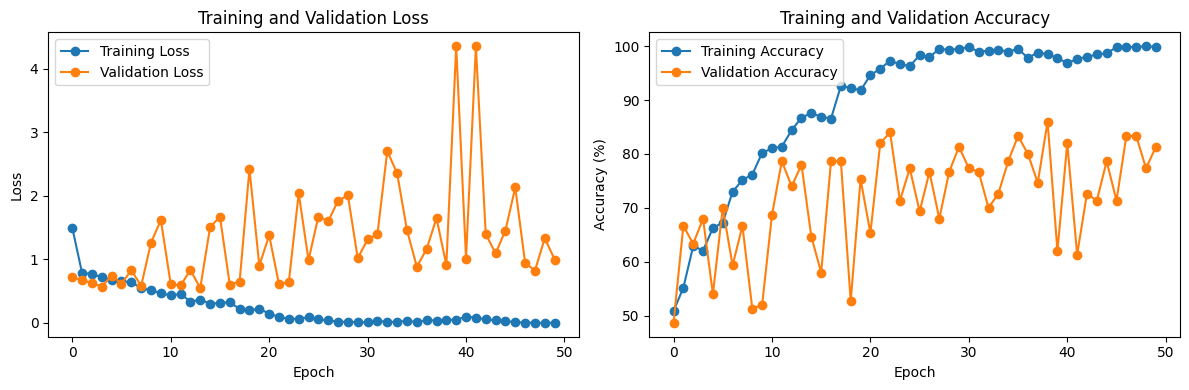

hystory of fold 1


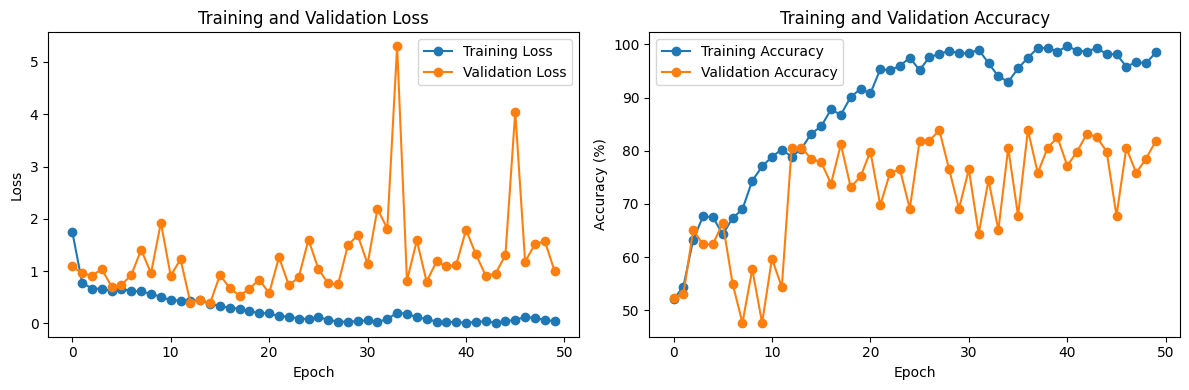

hystory of fold 2


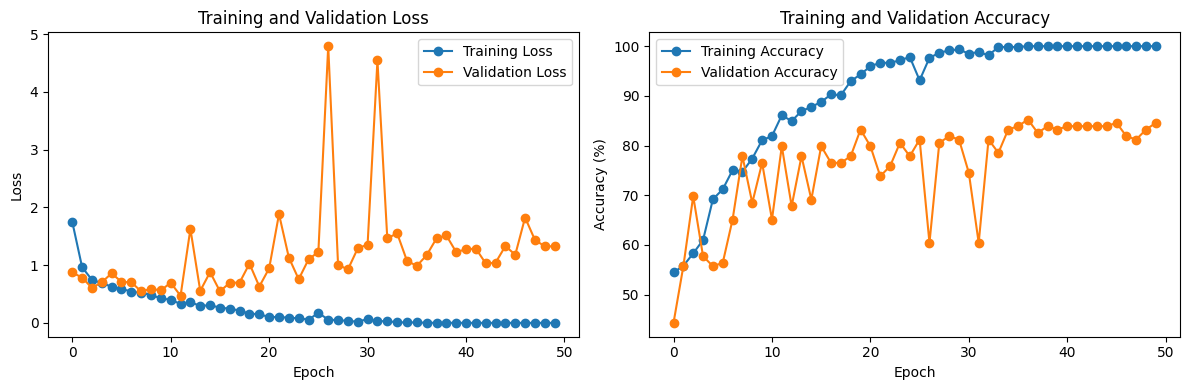

hystory of fold 3


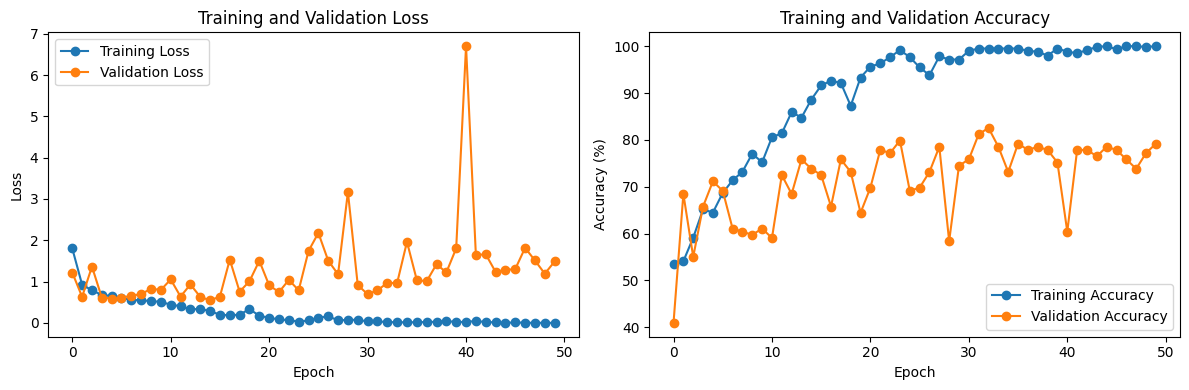

hystory of fold 4


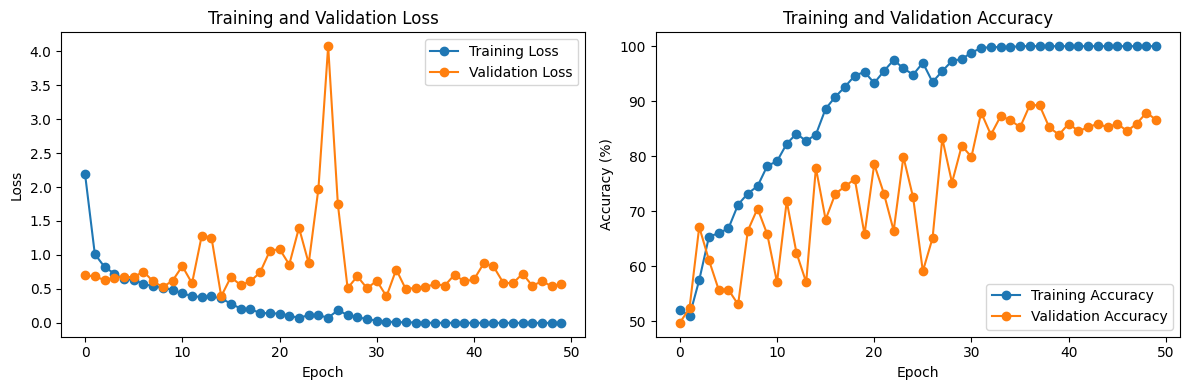

In [5]:
import matplotlib.pyplot as plt

f=0
for history in results["history"]:
    train_loss_history = history["train_loss"]
    train_accuracy_history = history["train_acc"]
    test_loss_history = history["test_loss"]
    test_accuracy_history = history["test_acc"]
    
    print(f'hystory of fold {f}')
    f+=1

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss', marker='o')
    plt.plot(test_loss_history, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, label='Training Accuracy', marker='o')
    plt.plot(test_accuracy_history, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()
